8.0
2.146240234375


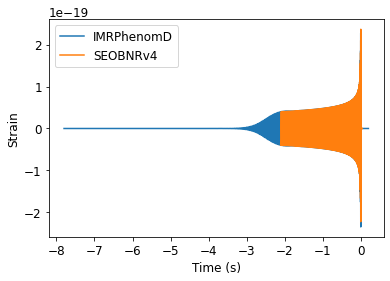

In [15]:
# %matplotlib inline
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from scipy.signal.windows import tukey
import numpy as np

from pycbc.types.timeseries import TimeSeries, FrequencySeries
from pycbc.psd import interpolate
from pycbc.detector import Detector

for apx in ['IMRPhenomD', 'SEOBNRv4']:
    hp, hc = get_td_waveform(approximant=apx,
                             mass1=10,
                             mass2=10,
                             spin1z=0.9,
                             delta_t=1.0/4096,
                             f_lower=30)

    plt.plot(hp.sample_times, hp, label=apx)
    print(hp.duration)

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

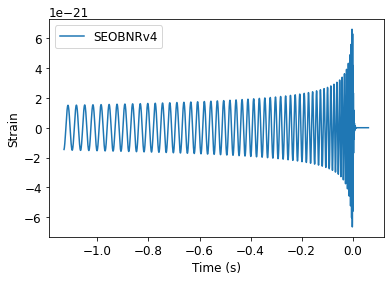

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform


for apx in ['SEOBNRv4']:
    hp, hc = get_td_waveform(approximant=apx,
                             mass1=17.599,
                             mass2=12.26,
                             distance=50,
                             spin1z=0.9,
                             delta_t=1.0/4096,
                             f_lower=30)

    plt.plot(hp.sample_times, hp, label=apx)

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [26]:
def fade_on(
        timeseries,
        alpha=0.25
):
    """
    Take a PyCBC time-series and use a one-sided Tukey window to "fade
    on" the waveform (to reduce discontinuities in the amplitude).

    Arguments:
        timeseries: pycbc.types.timeseries.TimeSeries
            TimeSeries object to be faded on.
        alpha: float
            The alpha parameter for the Tukey window.

    Returns:
        The `timeseries` which has been faded on.
    """

    # Save the parameters from the time-series we are about to fade on
    delta_t = timeseries.delta_t
    epoch = timeseries.start_time
    duration = timeseries.duration
    sample_rate = timeseries.sample_rate

    # Create a one-sided Tukey window for the turn on
    window = tukey(M=int(duration * sample_rate), alpha=alpha)
    window[int(0.5*len(window)):] = 1

    # Apply the one-sided Tukey window for the fade-on
    ts = window * np.array(timeseries)

    # Create and return a TimeSeries object again from the resulting array
    # using the original parameters (delta_t and epoch) of the time-series
    return TimeSeries(initial_array=ts,
                      delta_t=delta_t,
                      epoch=epoch)

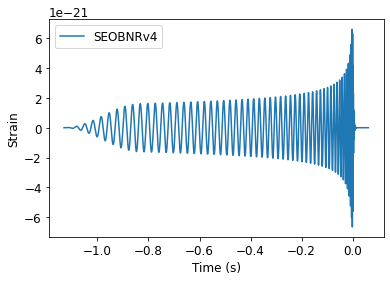

In [27]:
h_plus = fade_on(hp, alpha=0.5)
h_cross = fade_on(hc, alpha=0.5)

plt.plot(h_plus.sample_times, h_plus, label=apx)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

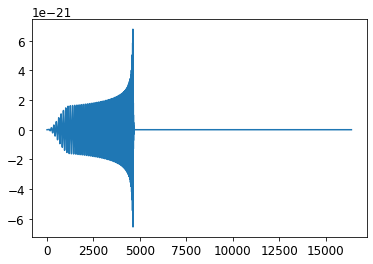

In [5]:
h_cross.resize(16384)

plt.plot(h_cross)

36864
36864
36864
[0. 0. 0. ... 0. 0. 0.]


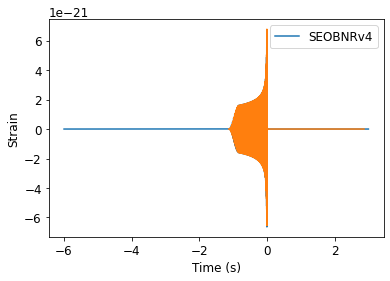

In [16]:
seconds_before_merger = 6
seconds_after_merger = 3
total_sample_length = seconds_before_merger + seconds_after_merger

sample_rate = h_plus.sample_rate
total_sample_length_points = int(total_sample_length * sample_rate)

print(len(h_plus))

# Raise an exception for if the seconds_before_merger is less than already exists
# this means we need to end the whole process and tell the user to fix the parameter
padding_before_merger = seconds_before_merger - abs(min(h_plus.sample_times))
points_before_merger = int(padding_before_merger * sample_rate)
h_plus.prepend_zeros(points_before_merger)
h_cross.prepend_zeros(points_before_merger)
print(len(h_plus))

points_after_merger = total_sample_length_points - len(h_plus)
h_plus.append_zeros(points_after_merger)
h_cross.append_zeros(points_after_merger)
print(len(h_plus))

print(h_plus)

plt.plot(h_plus.sample_times, h_plus, label=apx)
plt.plot(h_cross.sample_times, h_cross)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

36864


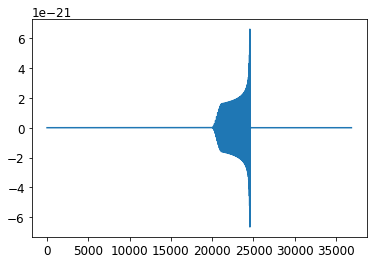

In [7]:
print(len(h_plus.data))

plt.plot(h_plus.data)

49152


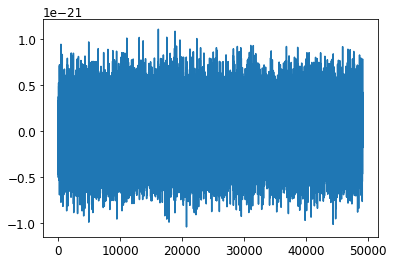

In [8]:
from pycbc.noise.gaussian import noise_from_psd
from pycbc.psd.analytical import aLIGOZeroDetHighPower

psd = aLIGOZeroDetHighPower(
    length=8192,
    delta_f=1,
    low_freq_cutoff=18
)

x = noise_from_psd(
    length=12*4096,
    delta_t=1.0/4096,
    psd=psd
)

print(len(x))

plt.plot(x)

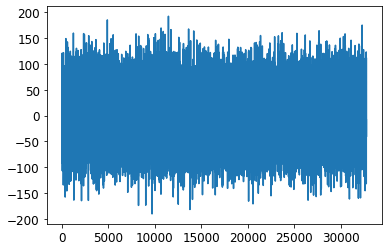

In [9]:
xx = x.whiten(4, 4)

plt.plot(xx)

0.08333333333333333
1
0.08333333333333333
0.08333333333333333
[       -inf       +nanj        -inf       +infj        -inf       +infj
 ...  0.33316592+0.6244435j  -0.01676847-0.26211355j
  0.13061139+0.j        ]
24577


/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:365: RuntimeWarning: divide by zero encountered in true_divide
  return self._data / other
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:365: RuntimeWarning: invalid value encountered in true_divide
  return self._data / other
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


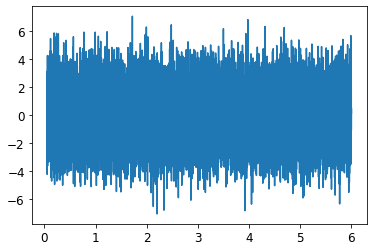

In [10]:
x_freq = x.to_frequencyseries()
print(x_freq.delta_f)
print(psd.delta_f)
psd = interpolate(psd, x_freq.delta_f)
print(psd.delta_f)

if x_freq.delta_f == psd.delta_f:
    new_psd = FrequencySeries(psd.data[:len(x_freq.data)], delta_f=x_freq.delta_f)

    
xx2 = (x.to_frequencyseries() / new_psd ** 0.5)

print(xx2.delta_f)

x2 = TimeSeries(xx2, delta_t=1.0/4096)

print(x2.data)
print(len(x2.data))

plt.plot(x2.sample_times, x2)

# plt.plot(new_psd.sample_frequencies, new_psd)

# plt.plot(x_freq.sample_frequencies, abs(x_freq))

45.25483399593904
36864


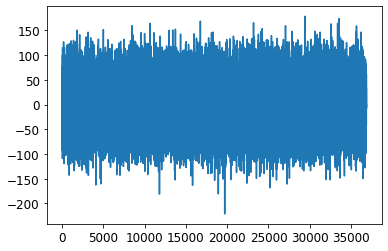

In [11]:
ts_std_dev = 1.0 / np.sqrt(2.0*1.0/4096)
print(ts_std_dev)

noise = np.random.normal(0, ts_std_dev, 9*4096)
print(len(noise))

plt.plot(noise)

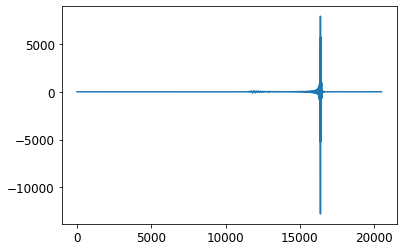

In [12]:
# Whitening the faded on and extended waveform

h_plus_whitened = h_plus.whiten(4,4)

plt.plot(h_plus_whitened)

In [13]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
new_sample_length = 10
first = (len(x) // 2) - (new_sample_length // 2)
last = first + new_sample_length

print(first)
print(last)
print(x[first:last])

3
13
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


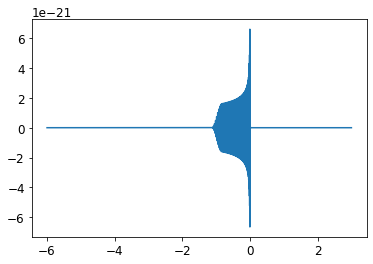

In [14]:
plt.plot(h_plus.sample_times, h_plus)

In [30]:
detector_name = 'H1'
detector = Detector(detector_name)

ra = 3.858
dec = 0.266
psi = 1.282

# Get the detector antenna pattern
fp, fc = detector.antenna_pattern(
    right_ascension=ra,
    declination=dec,
    polarization=psi,
    t_gps=100
)

# Calculate time offset relative to H1
delta_t_h1 = detector.time_delay_from_detector(
    other_detector=Detector('H1'),
    right_ascension=ra,
    declination=dec,
    t_gps=100
)

# Project to the new detector
detector_signal = fp*h_plus + fc*h_cross

# Map to specific detector
offset = 100 + delta_t_h1 + detector_signal.start_time
detector_signal = detector_signal.cyclic_time_shift(offset)
detector_signal.start_time = 1126259462.391 - 100

plt.plot(detector_signals.sample_times, detector_signals)
plt.show()

/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if precision is 'single':
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if precision is 'single':
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dtype.kind is 'c':
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:862: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.kind is 'real' and other.kind is 'complex':
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py:862: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.kind is 'real' and other.kind is 'complex':
/home/damon/anaconda3/envs/gravflows/lib/python3.8/site-packages/pycbc/types/array.py

TypeError: unsupported operand type(s) for *: 'float' and 'lal.LIGOTimeGPS'

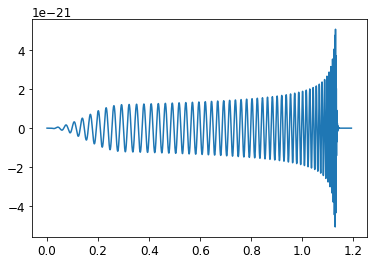

In [31]:
detector_name = 'H1'
detector = Detector(detector_name)

ra = 3.858
dec = 0.266
psi = 1.282
time = 1000000000

# Get the detector antenna pattern
fp, fc = detector.antenna_pattern(
    right_ascension=ra,
    declination=dec,
    polarization=psi,
    t_gps=time
)

ht = TimeSeries(fp.data*h_plus.data + fc.data*h_cross.data, delta_t=1.0/4096)

# h_plus.start_time = h_cross.start_time = time
# ht = detector.project_wave(h_plus, h_cross, ra, dec, psi)



plt.plot(ht.sample_times, ht)
plt.show()